# Fuzzy classification

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz

from skfuzzy.cluster import cmeans
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from scipy.spatial.distance import mahalanobis

from itertools import product

## Difference between hard clustering and soft (fuzzy) clustering

In [85]:
def generate_noisy_distribution(centroids, num_samples, noise_std):
    num_centroids = len(centroids)
    dimensions = len(centroids[0])

    data = np.zeros((num_samples * num_centroids, dimensions))

    for i in range(num_centroids):
        centroid = centroids[i]
        samples = np.random.normal(loc=centroid, scale=noise_std, size=(num_samples, dimensions))
        data[i*num_samples: (i+1)*num_samples, :] = samples

    return data

# Define the centroids
centroids = np.array(list(product([-1, 1], repeat=2)))

# Generate the noisy distribution
num_samples = 1000
noise_std = 0.5
data = generate_noisy_distribution(centroids, num_samples, noise_std)

In [89]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=4, n_init=1, init=centroids)
kmeans.fit(data)
labels_kmeans = kmeans.labels_

# Assign colors based on cluster labels
colors_kmeans = ["#FF0000" if label == 0 else "#00FF00" if label == 1 else "#0000FF" if label == 3 else "#000000" for label in labels_kmeans]

In [87]:
def generate_rgb_colors(memberships):
    colors = []
    for m in memberships:
        rgb = (m[0], m[1], m[2])
        colors.append(rgb)
    return colors

# Apply Fuzzy C-Means clustering
n_clusters = len(centroids)
m = 2
max_iter = 100
tolerance = 0.001

# FCM clustering
centers, memberships, _, _, _, _, _ = cmeans(data.T, n_clusters, m, error=tolerance,
                                             maxiter=max_iter, init=None)
# Generate RGB colors based on membership values
colors_fcm = generate_rgb_colors(memberships.T)

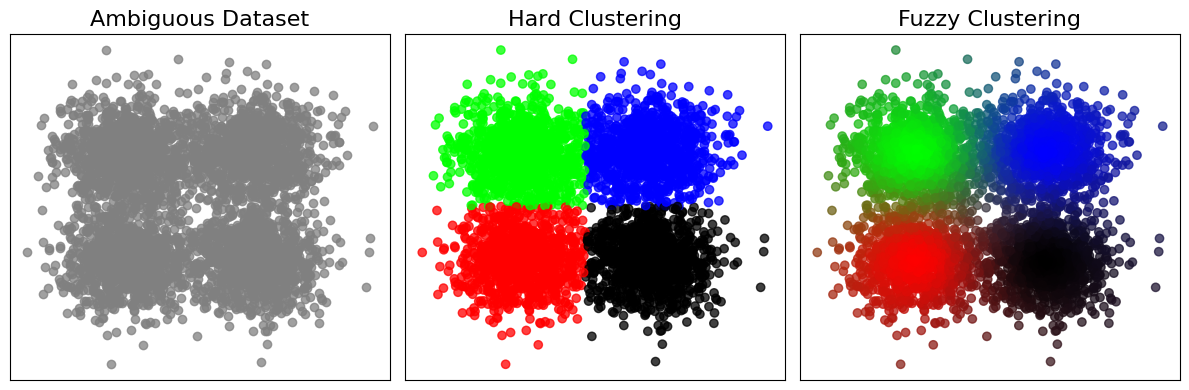

In [91]:
plt.figure(figsize=(12, 4), layout="tight")

plt.subplot(1, 3, 1)
# Plot the distribution
plt.scatter(data[:, 0], data[:, 1], color="gray", alpha=0.75)
plt.title('Ambiguous Dataset', fontsize="16")
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 2)
# Plot K-Means
plt.scatter(data[:, 0], data[:, 1], color=colors_kmeans, alpha=0.75)
plt.title('Hard Clustering', fontsize="16")
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 3)
# Plot FCM
plt.scatter(data[:, 0], data[:, 1], color=colors_fcm, alpha=0.75)
plt.title('Fuzzy Clustering', fontsize="16")
plt.xticks([])
plt.yticks([])

# Save the figure in SVG format
plt.savefig('hard_vs_soft.svg', format='svg')
plt.show()

In [20]:
def compute_membership(data, centers, covariance_matrices, m):
    membership = np.zeros((data.shape[0], centers.shape[0]))
    for i, x in enumerate(data):
        for j, c in enumerate(centers):
            distance = mahalanobis(x, c, covariance_matrices[j])
            membership[i, j] = 1 / np.sum((distance / mahalanobis(x, centers, covariance_matrices)) ** (2 / (m - 1)))

    return membership

def update_centers(data, membership, m):
    centers = np.zeros((membership.shape[1], data.shape[1]))
    for j in range(membership.shape[1]):
        membership_m = membership[:, j] ** m
        centers[j] = np.sum(data * membership_m[:, np.newaxis], axis=0) / np.sum(membership_m)

    return centers

def compute_covariance_matrices(data, centers, membership, m):
    covariance_matrices = []
    for j in range(membership.shape[1]):
        membership_m = membership[:, j] ** m
        weighted_data = data * np.sqrt(membership_m[:, np.newaxis])
        centered_data = weighted_data - centers[j]
        covariance_matrix = np.dot(centered_data.T, centered_data) / np.sum(membership_m)
        covariance_matrices.append(covariance_matrix)

    return covariance_matrices

def gkm_clustering(data, centers, m, max_iter=100, tol=1e-4):
    # Initialize centers randomly
    if centers is None:
        centers = data[np.random.choice(data.shape[0], n_clusters, replace=False)]
    
    # Initialize covariance matrices
    covariance_matrices = [np.eye(data.shape[1])] * len(centers)

    for _ in range(max_iter):
        prev_centers = np.copy(centers)

        # Compute membership
        membership = compute_membership(data, centers, covariance_matrices, m)

        # Update centers
        centers = update_centers(data, membership, m)

        # Compute covariance matrices
        covariance_matrices = compute_covariance_matrices(data, centers, membership, m)

        # Check convergence
        if np.linalg.norm(centers - prev_centers) < tol:
            break

    # Assign labels based on the maximum membership
    labels = np.argmax(membership, axis=1)

    return centers, labels

# Generate an elliptical dataset
n_samples = 1000
centers = [[-2, 0], [2, 0]]
cluster_std = [1, 0.5]  # Adjust the standard deviations to control ellipticity
X, _ = make_blobs(n_samples=n_samples, centers=centers, cluster_std=cluster_std, random_state=42)

# Perform GKM clustering
n_clusters = 2
m = 2
max_iter = 100
tolerance = 1e-4
gkm_centers, gkm_labels = gkm_clustering(X, n_clusters, m, max_iter, tolerance)

# Plot the results
plt.scatter(X[:, 0], X[:, 1], c=gkm_labels, cmap='viridis', alpha=0.5)
plt.scatter(gkm_centers[:, 0], gkm_centers[:, 1], c='red', marker='x', label='Centroids')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Gustafson-Kessel Means Clustering')
plt.legend()
plt.grid(True)
plt.show()


TypeError: object of type 'int' has no len()